In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pymongo
import pandas as pd

from numpy.polynomial.polynomial import polyfit

from constants import *

In [2]:
client = pymongo.MongoClient('localhost', 27017)
db = client.mineral_db

In [3]:
minerals_in_pgm = {}

for x in db.mineral_coll.find():
    mineral = x['mineral_name']
    
    try:
        pgms = x['pgm']
    except:
        continue
        
    for pgm in pgms:
        if pgm in minerals_in_pgm.keys():
            minerals_in_pgm[pgm].append(mineral)
        else:
            minerals_in_pgm[pgm] = [ mineral ]

In [4]:
pgm_attrs = pd.read_csv('data/2022_pgm_attributes.csv',
                        index_col='MODE'
                       ).transpose()
pgm_attrs.columns = [ s.lower() for s in pgm_attrs.columns ]

def get_attr(p, prop):
    if p[:-1] == 'p45':
        p = 'p45'
        
    if p[:-1] == 'p47':
        p = 'p47'
        
    return pgm_attrs[p][prop]


T_MIN = 'Temp (min) K'
T_MAX = 'Temp (max) K'
T_AVG = 'Temp (average) K'

P_MIN = 'P (min) log Pa'
P_MAX = 'P (max) log Pa'
P_AVG = 'P (average log Pa)'

In [5]:
symmetry_indices = {
    'amorphous': 1,
    'triclinic': 2,
    'monoclinic': 4,
    'orthorhombic': 8,
    'trigonal': 12,
    'tetragonal': 16,
    'hexagonal': 24,
    'cubic': 48
}

pgm_symmetry_indices = {}
pgm_populations = {}
n_minerals_in_pgm = {}

for p in minerals_in_pgm.keys():
    pgm_pop = { cs: 0 for cs in symmetry_indices.keys() }
    num_minerals = 0
    pgm_sym_ind = 0
    
    for x in db.mineral_coll.find({ 'mineral_name': { '$in': minerals_in_pgm[p] } }):
        for crystal_system in x['crystal_systems']:
            if crystal_system in symmetry_indices.keys():
                pgm_pop[crystal_system] += 1
                num_minerals += 1
                pgm_sym_ind += symmetry_indices[crystal_system]
            
    try:
        pgm_symmetry_indices[p] = pgm_sym_ind / symmetry_indices['cubic'] / num_minerals
    except Exception as e:
        print(e)
        
    pgm_populations[p] = pgm_pop
    n_minerals_in_pgm[p] = num_minerals
    
pgm_symmetry_indices = { p: pgm_symmetry_indices[p] for p in sorted(pgm_symmetry_indices) }

float division by zero


In [6]:
def plot_pgm(ordering, name, n_plots=3, nums=False):
    fig, ax = plt.subplots(n_plots, figsize=(15, 10*n_plots))
    l = len(ordering)//n_plots
    
    if len(ordering) % n_plots != 0:
        l += 1

    for i in range(n_plots):
        s, e = i*l, (i+1)*l

        r = len(ordering[s:e])
        bars = ax[i].bar(range(r), [ pgm_symmetry_indices[p] for p in ordering[s:e] ])
        ax[i].set_xticks(range(r), labels=ordering[s:e])
        ax[i].tick_params(axis='both', labelsize=FS_TICK)
        ax[i].set_title(f'Symmetry index of different paragenetic modes ({i+1}/{n_plots})', fontsize=FS_TITLE)

    # [ print(f'{p}:\t {sym:.3f}') for p, sym in pgm_symmetry_indices.items() ]

        if nums:
            for n_minerals, bar in zip([ n_minerals_in_pgm[p] for p in ordering[s:e] ], bars):
                ax[i].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                           f'{n_minerals}',
                           ha='center', va='bottom', fontsize=FS_SAMPLE
                          )

    plt.savefig(f'results/{name}.png')
    
default_ordering = list(pgm_symmetry_indices.keys())[1:]

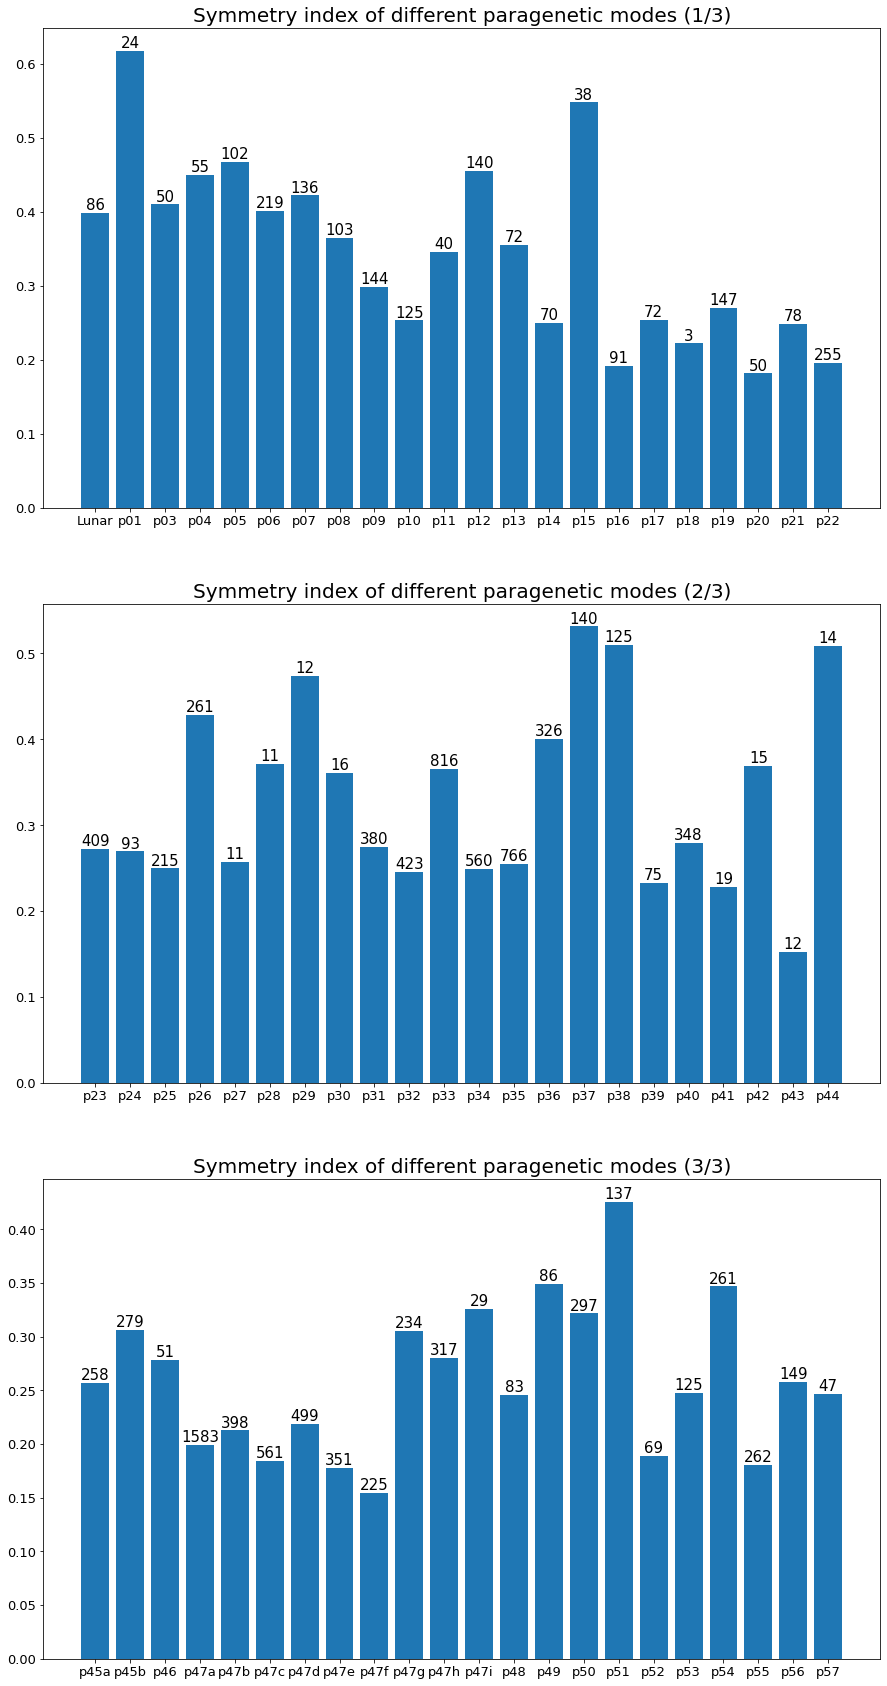

In [7]:
plot_pgm(['Lunar'] + default_ordering, 'graph_pgm', nums=True)

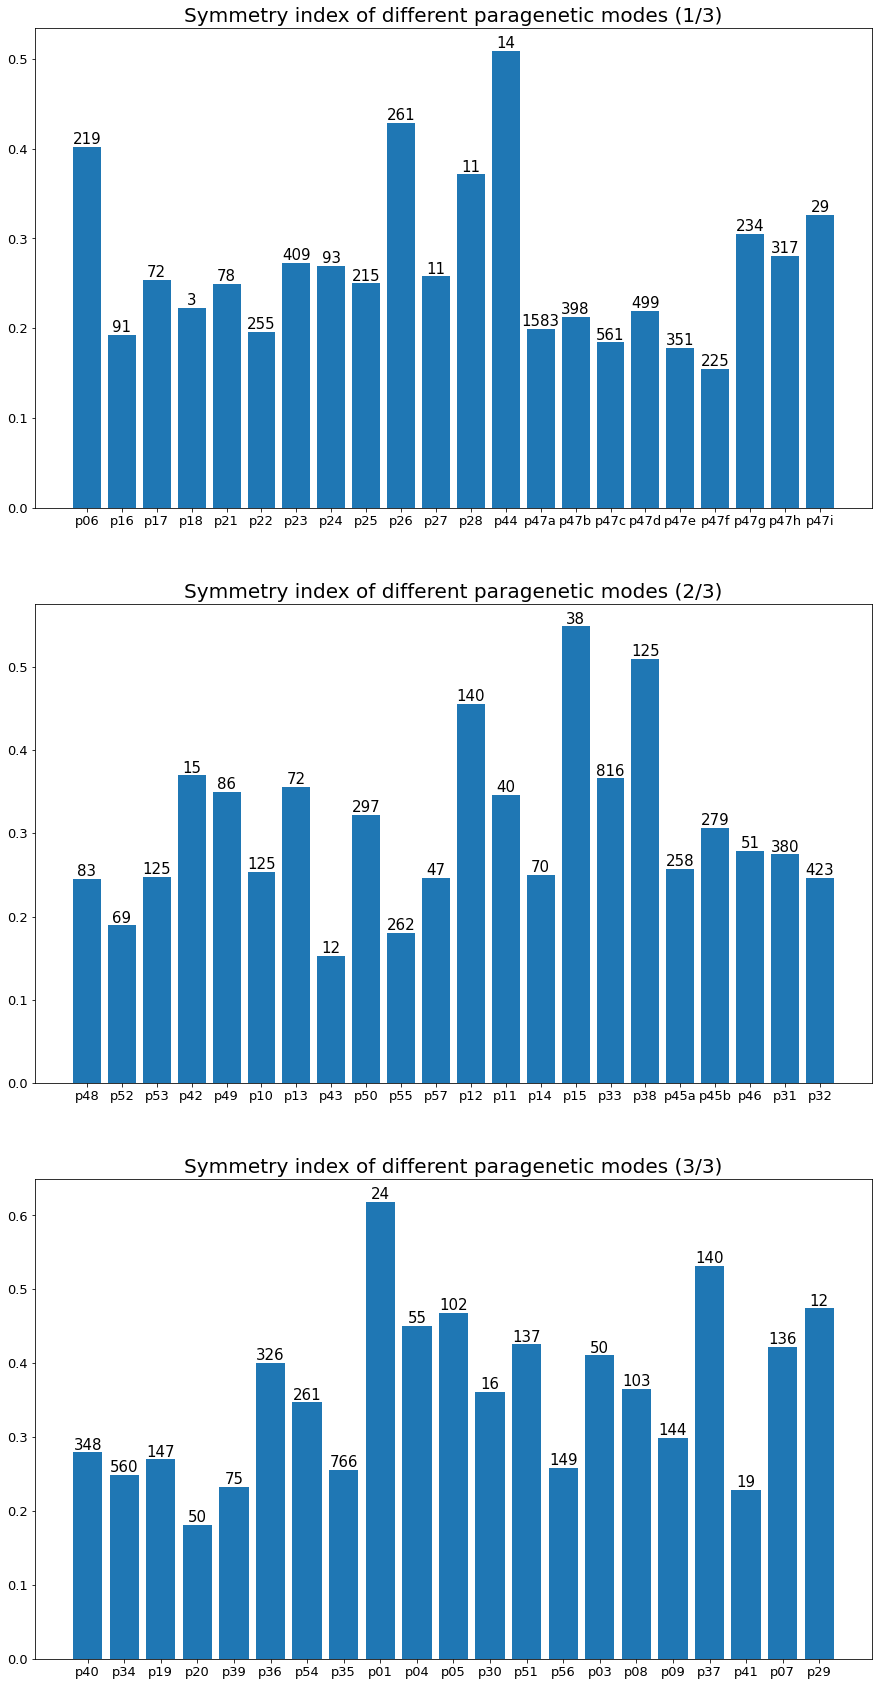

In [8]:
t_min_ordering = sorted(default_ordering, key=lambda p: get_attr(p, T_MIN))
plot_pgm(t_min_ordering, 'graph_pgm_tmin', nums=True)

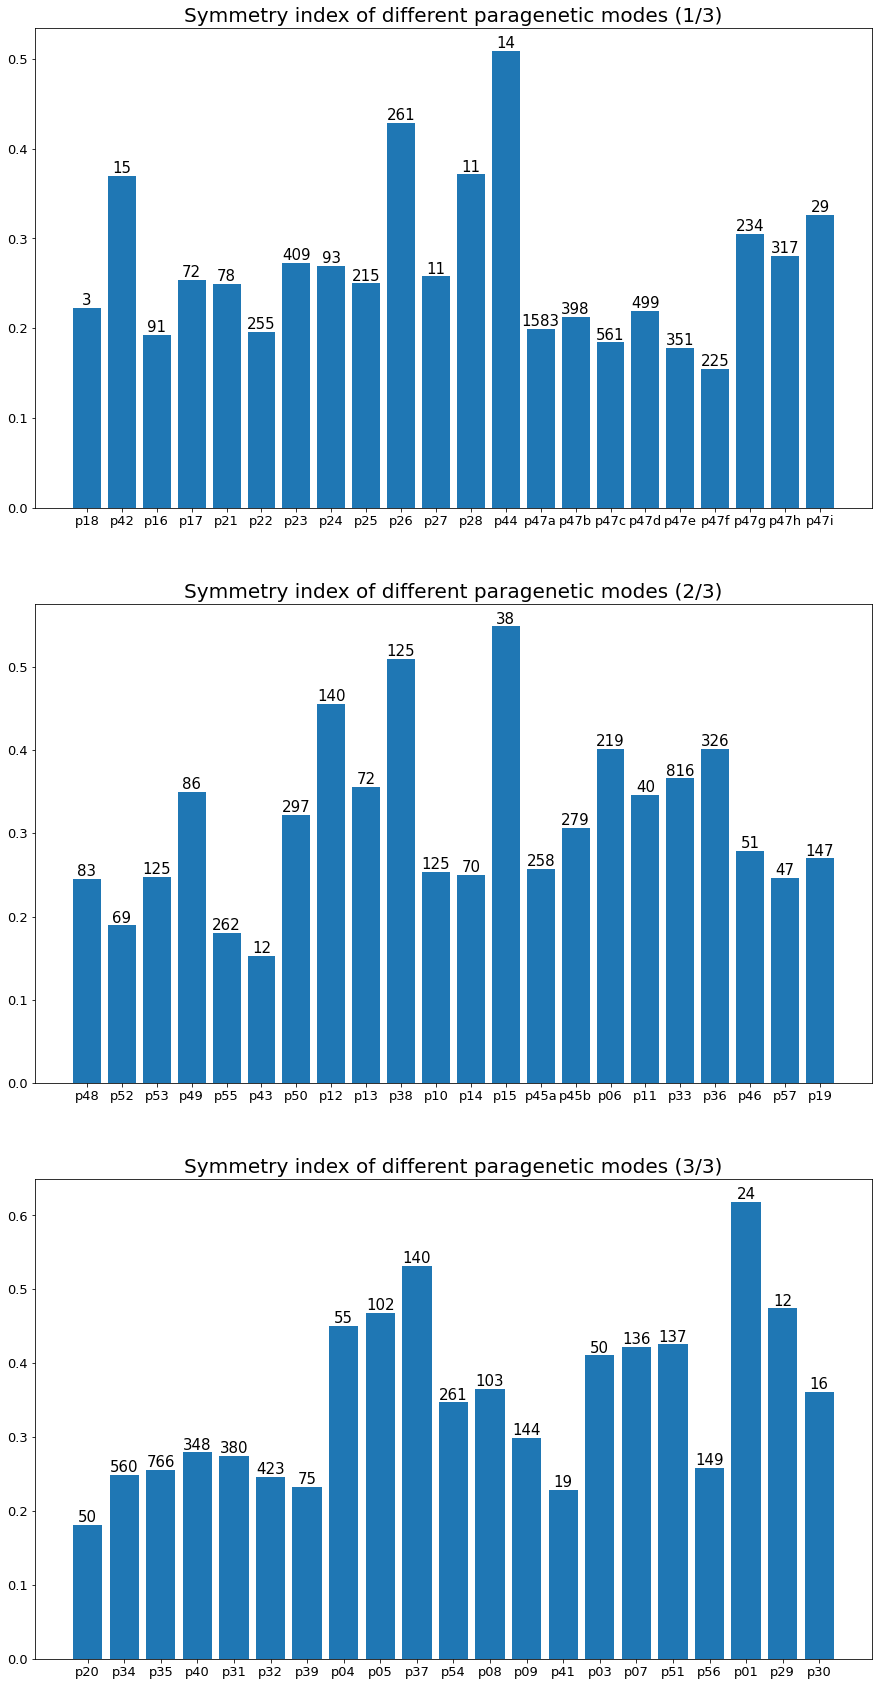

In [9]:
t_max_ordering = sorted(default_ordering, key=lambda p: get_attr(p, T_MAX))
plot_pgm(t_max_ordering, 'graph_pgm_tmax', nums=True)

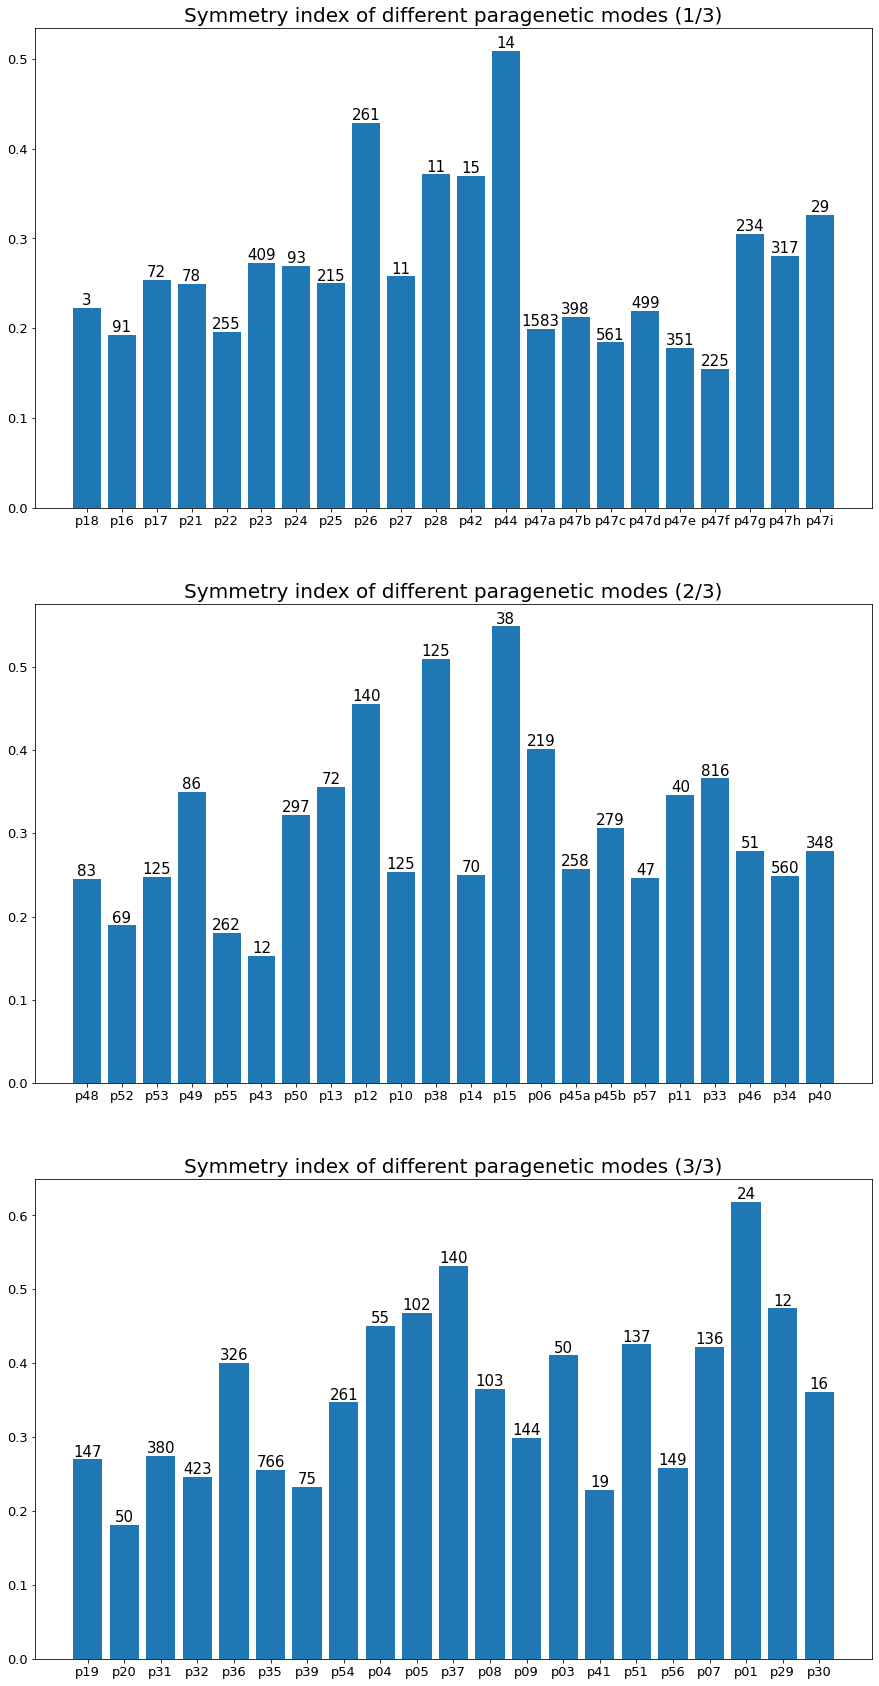

In [10]:
t_avg_ordering = sorted(default_ordering, key=lambda p: get_attr(p, T_AVG))
plot_pgm(t_avg_ordering, 'graph_pgm_tavg', nums=True)

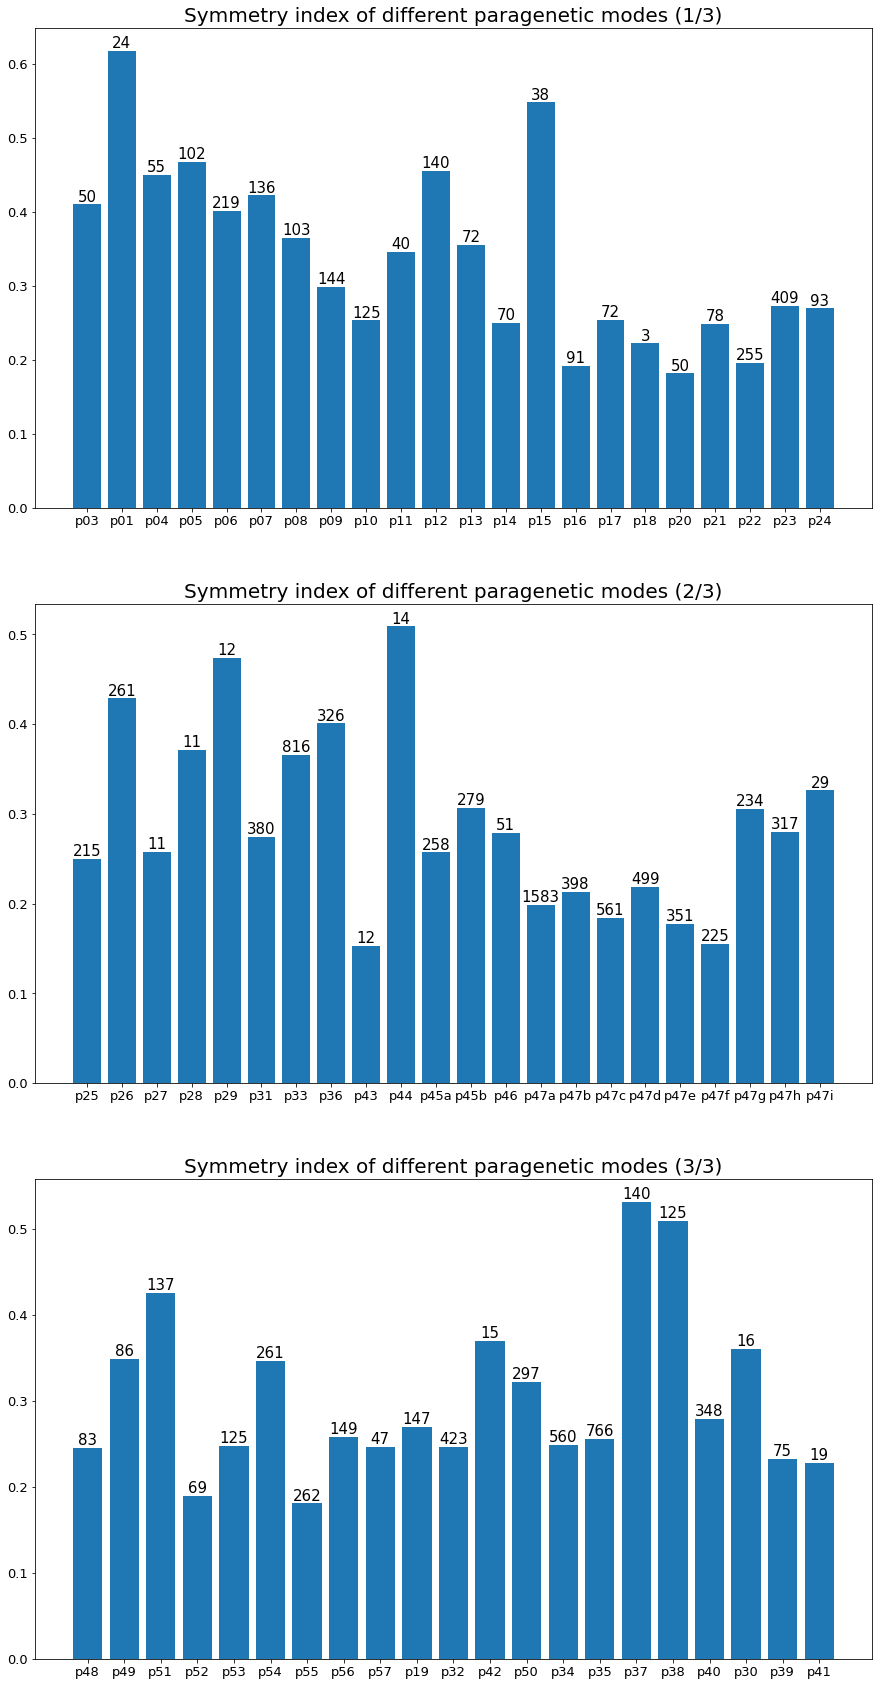

In [11]:
p_min_ordering = sorted(default_ordering, key=lambda p: get_attr(p, P_MIN))
plot_pgm(p_min_ordering, 'graph_pgm_pmin', nums=True)

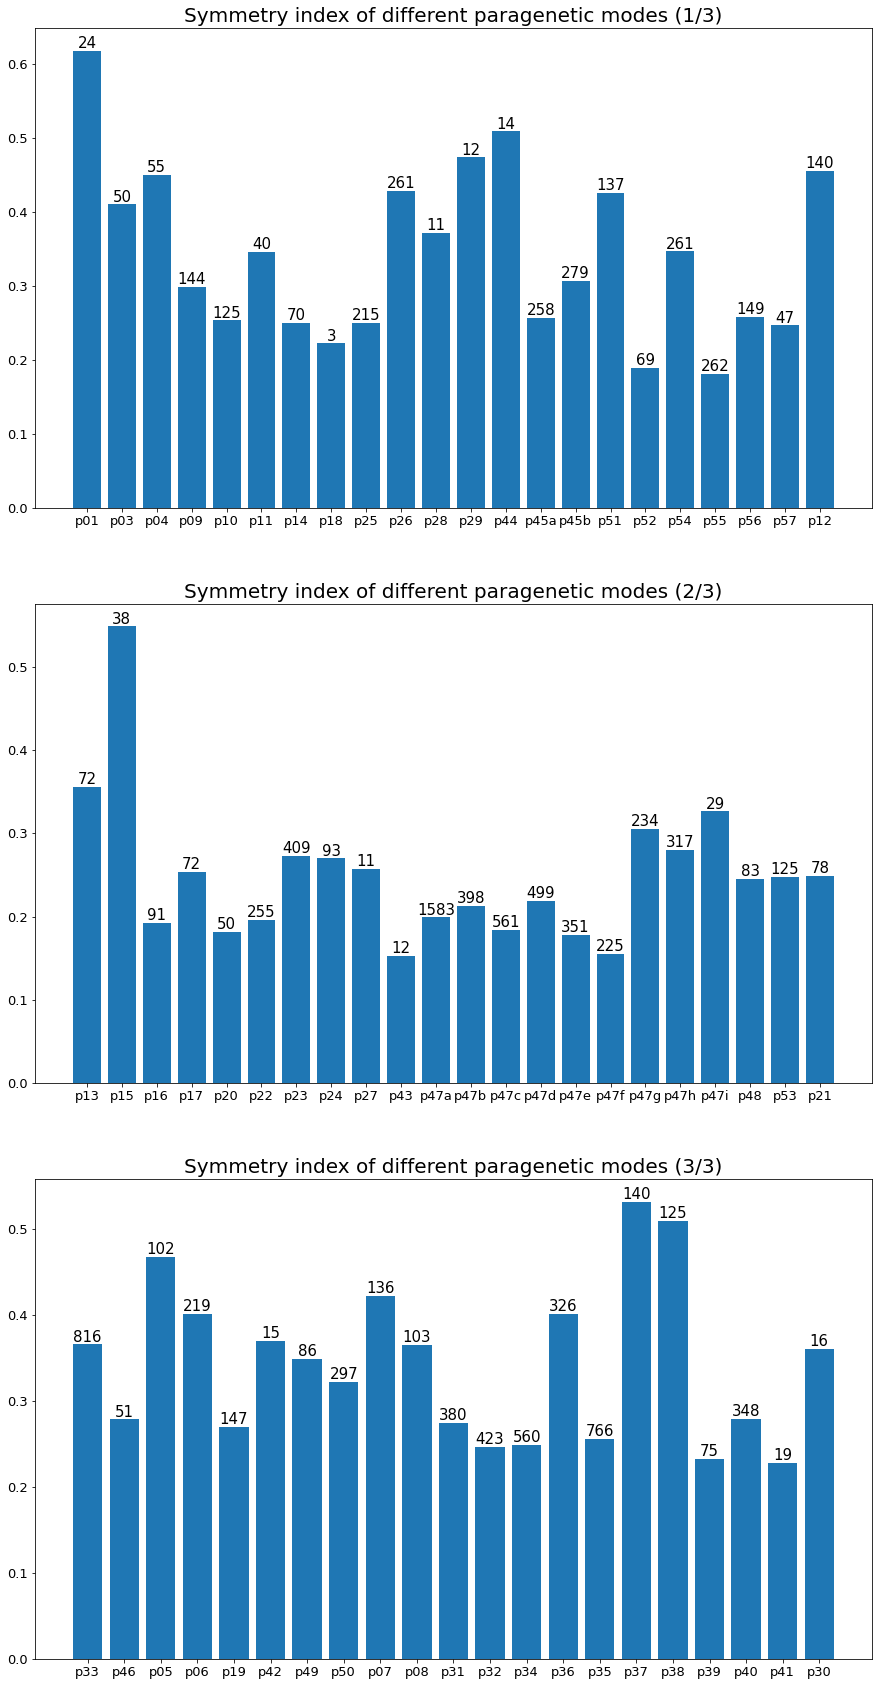

In [12]:
p_max_ordering = sorted(default_ordering, key=lambda p: get_attr(p, P_MAX))
plot_pgm(p_max_ordering, 'graph_pgm_pmax', nums=True)

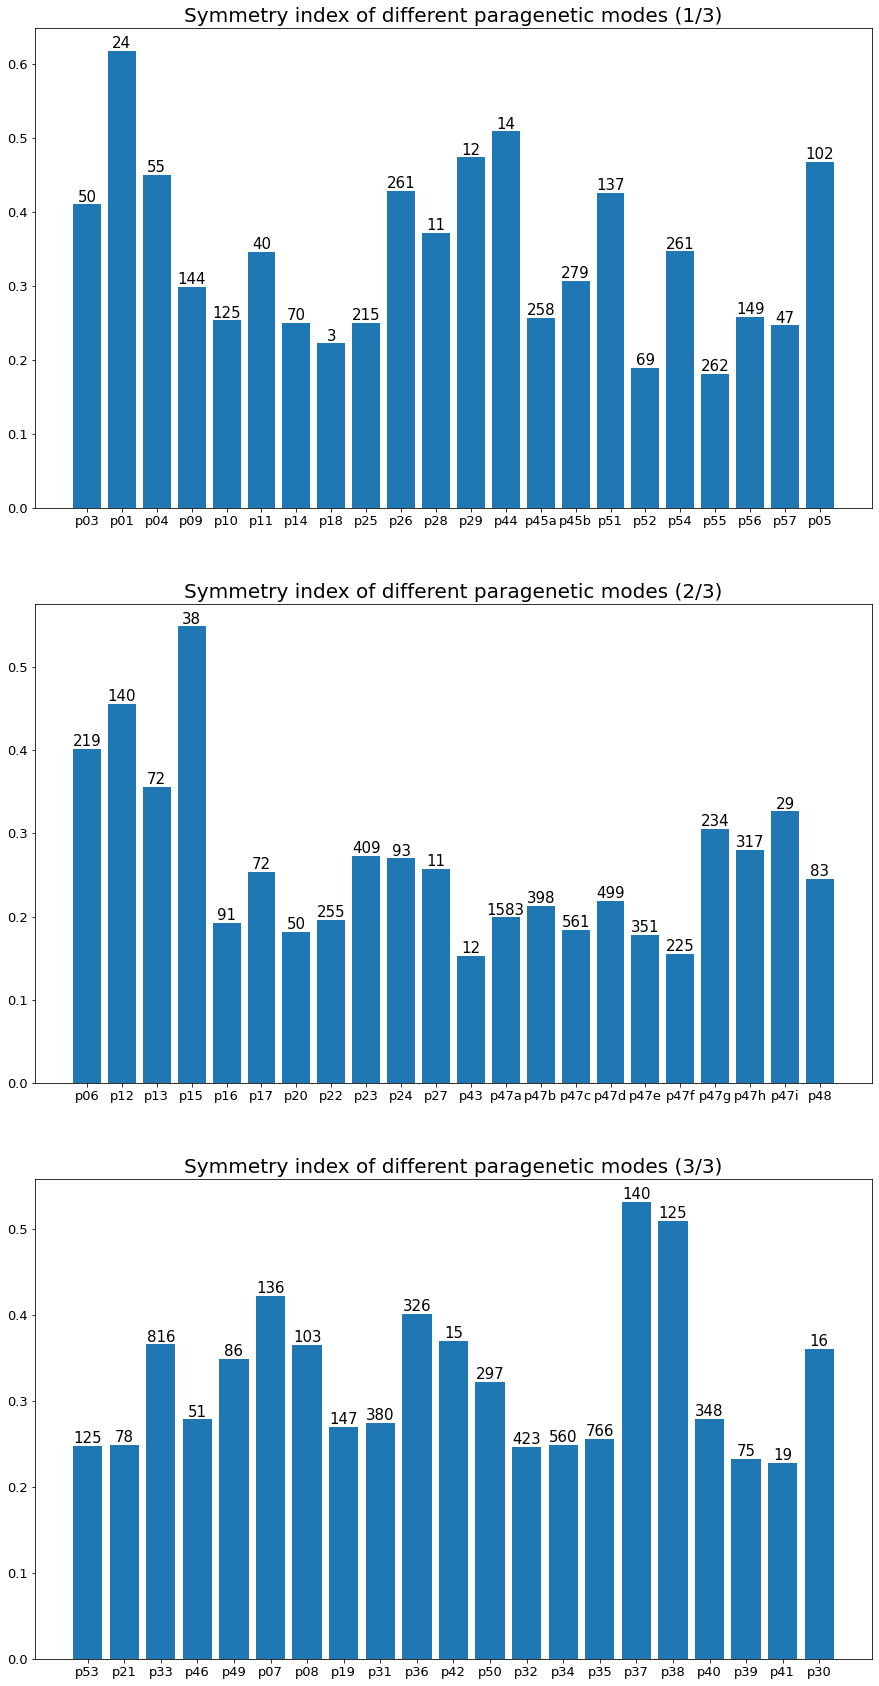

In [13]:
p_avg_ordering = sorted(default_ordering, key=lambda p: get_attr(p, P_AVG))
plot_pgm(p_avg_ordering, 'graph_pgm_pavg', nums=True)

In [14]:
def sym_ind(CRIT):
    crit_symmetry_indices = {}
    crit_populations = {}
    n_minerals_in_crit = {}
    
    for p in minerals_in_pgm.keys():
        if p == 'Lunar' or p == 'p02':
            continue

        pgm_pop = { cs: 0 for cs in symmetry_indices.keys() }
        num_minerals = 0
        pgm_sym_ind = 0

        for x in db.mineral_coll.find({ 'mineral_name': { '$in': minerals_in_pgm[p] } }):
            for crystal_system in x['crystal_systems']:
                if crystal_system in symmetry_indices.keys():
                    pgm_pop[crystal_system] += 1
                    num_minerals += 1
                    pgm_sym_ind += symmetry_indices[crystal_system]

        try:
            crit_sym_ind_part = pgm_sym_ind / symmetry_indices['cubic'] / num_minerals
        except Exception as e:
            print(e)

        crit = get_attr(p, CRIT)

        if crit in crit_symmetry_indices.keys():
            crit_pop = crit_populations[crit]
            crit_populations[crit] = { cs: crit_pop[cs] + pgm_pop[cs] for cs in symmetry_indices.keys() }

            n_tmp = n_minerals_in_crit[crit] + num_minerals
            crit_symmetry_indices[crit] = (crit_symmetry_indices[crit] * n_minerals_in_crit[crit]\
                                            + crit_sym_ind_part * num_minerals) / n_tmp

            n_minerals_in_crit[crit] = n_tmp
        else:
            crit_symmetry_indices[crit] = crit_sym_ind_part
            crit_populations[crit] = pgm_pop
            n_minerals_in_crit[crit] = num_minerals


    crit_symmetry_indices = { crit: crit_symmetry_indices[crit] for crit in sorted(crit_symmetry_indices) }
    
    return crit_symmetry_indices, n_minerals_in_crit, crit_populations

In [15]:
crit_symmetry_indices, n_minerals_in_crit, crit_avg_populations = {}, {}, {}

for CRIT in [ T_MIN, T_MAX, T_AVG, P_MIN, P_MAX, P_AVG ]:
    crit_symmetry_indices[CRIT], n_minerals_in_crit[CRIT], crit_avg_populations[CRIT] = sym_ind(CRIT)

In [40]:
def plot_crit(CRIT, name, n_plots=1, nums=False):
    fig, ax = plt.subplots(n_plots, figsize=(15, 10*n_plots))
    ordering = list(crit_symmetry_indices[CRIT].keys())
    l = len(ordering)//n_plots
    
    if n_plots == 1:
        ax = [ax]
    
    if len(ordering) % n_plots != 0:
        l += 1

    for i in range(n_plots):
        s, e = i*l, (i+1)*l
        
        num_name = f' ({(i+1)/n_plots})' if n_plots > 1 else ''
        crit_name = " ".join(CRIT.split()[:2])

        r = len(ordering[s:e])
        ret = [ crit_symmetry_indices[CRIT][p] for p in ordering[s:e] ]
        
        bars = ax[i].bar(range(r), ret)
        ax[i].set_xticks(range(r), labels=ordering[s:e])
        ax[i].tick_params(axis='both', labelsize=FS_TICK)
        ax[i].set_title(f'Symmetry index by {crit_name}{num_name}', fontsize=FS_TITLE)
        plt.xlabel(CRIT, fontsize=20)

    # [ print(f'{p}:\t {sym:.3f}') for p, sym in pgm_symmetry_indices.items() ]

        if nums:
            for n_minerals, bar in zip([ n_minerals_in_crit[CRIT][p] for p in ordering[s:e] ], bars):
                ax[i].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                           f'{n_minerals}',
                           ha='center', va='bottom', fontsize=FS_SAMPLE
                          )

    plt.savefig(f'results/{name}.png')
    return ordering, ret

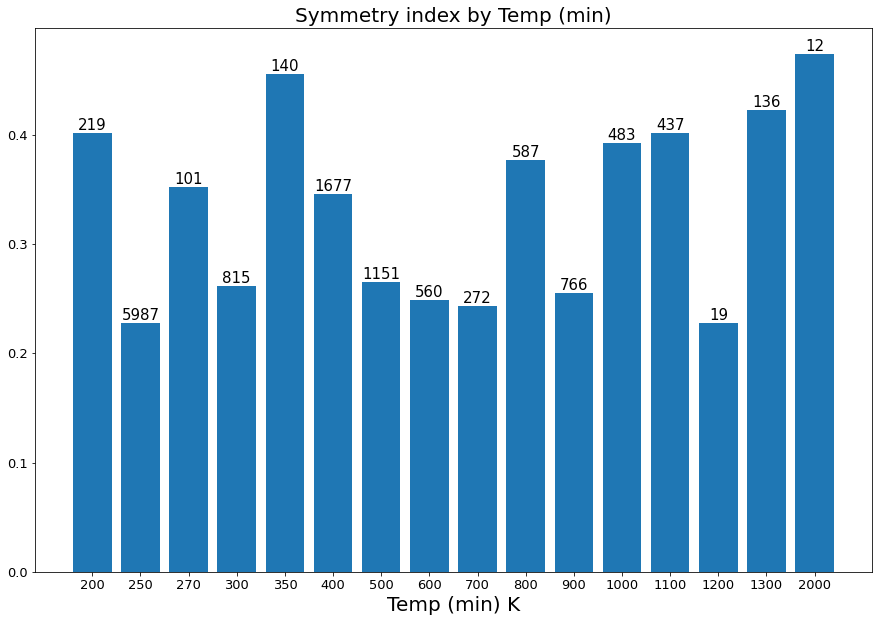

In [41]:
tmin_vals, tmin_syms = plot_crit(T_MIN, 'graph_tmin', nums=True)

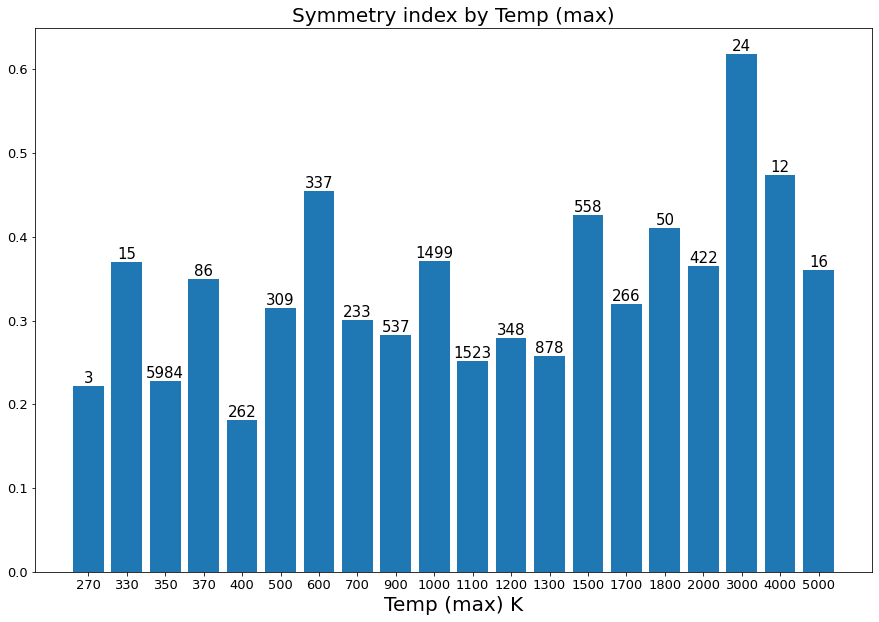

In [24]:
plot_crit(T_MAX, 'graph_tmax', nums=True)

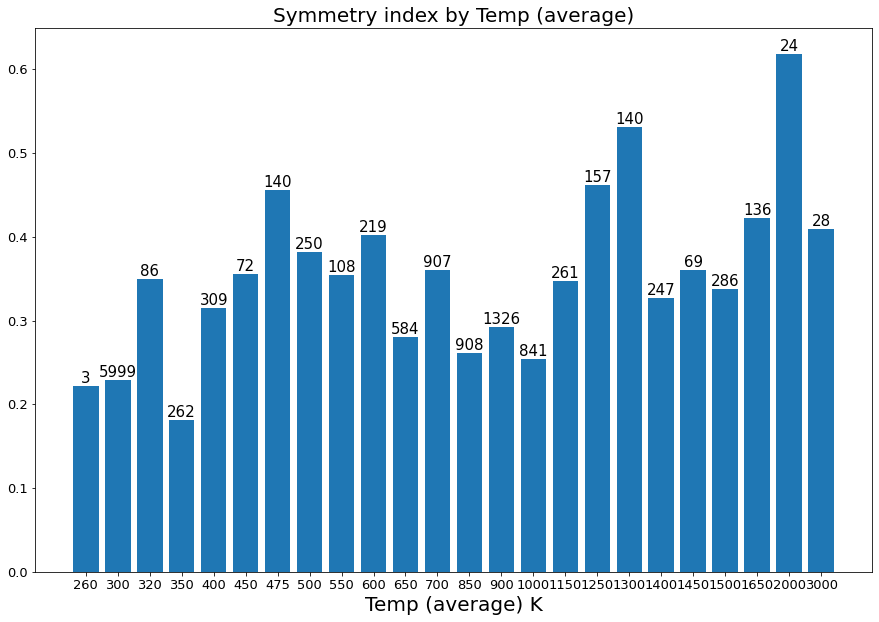

In [25]:
plot_crit(T_AVG, 'graph_tavg', nums=True)

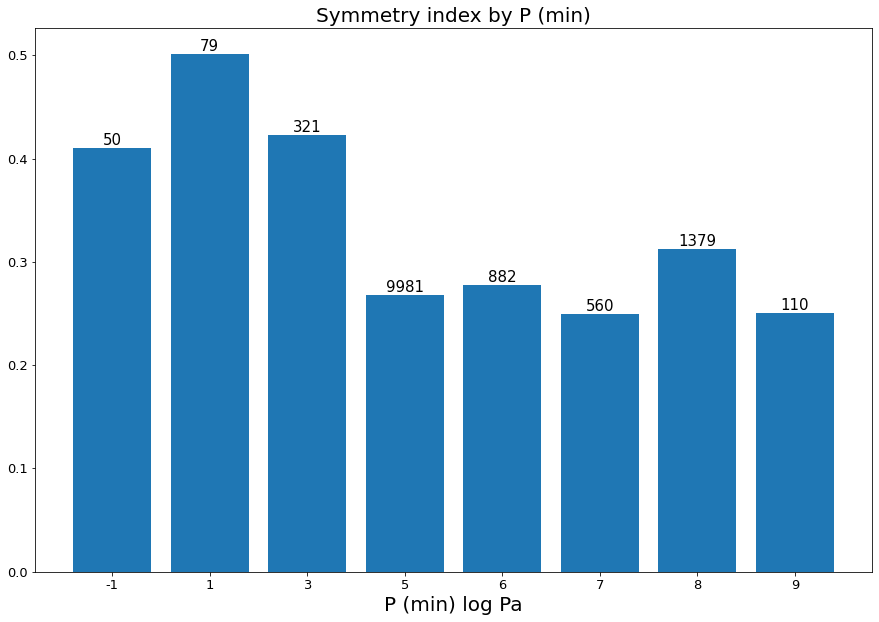

In [26]:
plot_crit(P_MIN, 'graph_pmin', nums=True)

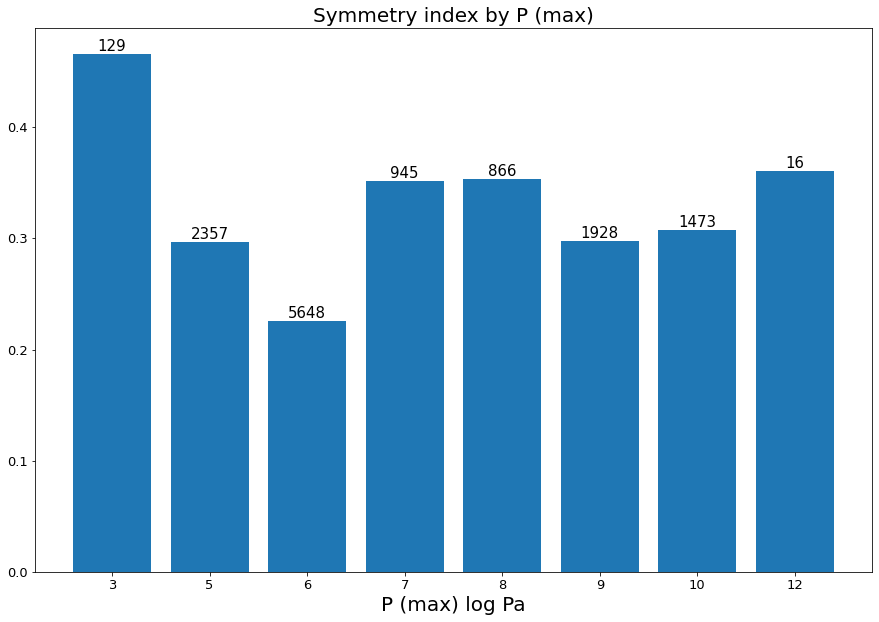

In [27]:
plot_crit(P_MAX, 'graph_pmax', nums=True)

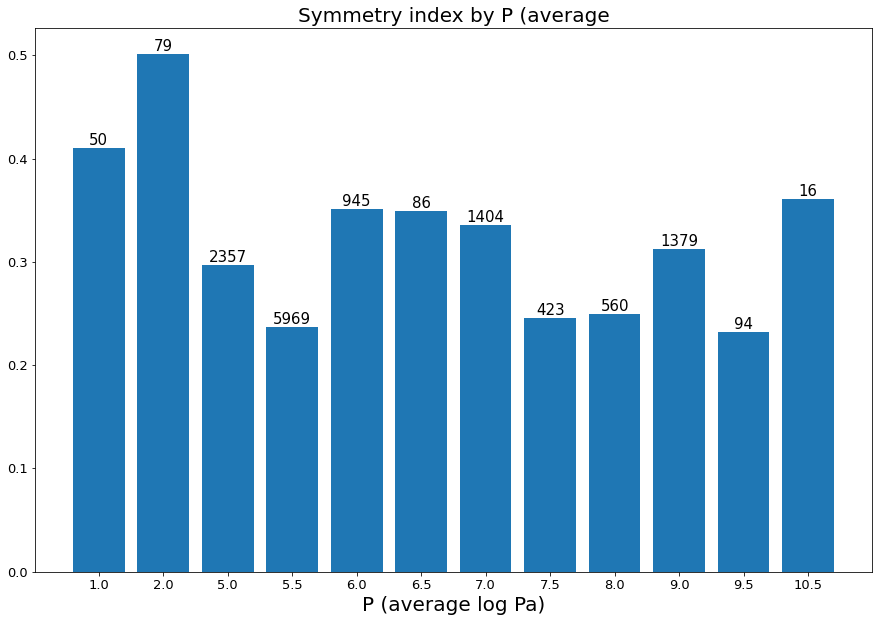

In [28]:
plot_crit(P_AVG, 'graph_pavg', nums=True)

In [100]:
def scatter_crit(CRIT, name, end=None, nums=False):
    plt.figure(figsize=(15, 10))
    ordering = list(crit_symmetry_indices[CRIT].keys())[:end]
    syms = [ crit_symmetry_indices[CRIT][p] for p in ordering ]
    l = len(ordering)

    crit_name = " ".join(CRIT.split()[:2])
    
    fit_lin = polyfit(ordering, syms, 1)
    fit_quad = polyfit(ordering, syms, 2)
    
    offset = max(ordering) / 50
    xs = np.linspace(min(ordering) - offset, max(ordering) + offset, 10000)
    plt.plot(xs, np.poly1d(fit_lin[::-1])(xs))
    plt.plot(xs, np.poly1d(fit_quad[::-1])(xs))
    
    plt.scatter(ordering, syms)
    
    plt.tick_params(axis='both', labelsize=FS_TICK)
    plt.title(f'Symmetry index by {crit_name}', fontsize=FS_TITLE)
    plt.xlabel(CRIT, fontsize=20)

    # [ print(f'{p}:\t {sym:.3f}') for p, sym in pgm_symmetry_indices.items() ]

#         if nums:
#             for n_minerals, bar in zip([ n_minerals_in_crit[CRIT][p] for p in ordering[s:e] ], bars):
#                 ax[i].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
#                            f'{n_minerals}',
#                            ha='center', va='bottom', fontsize=FS_SAMPLE
#                           )

    plt.savefig(f'results/{name}.png')

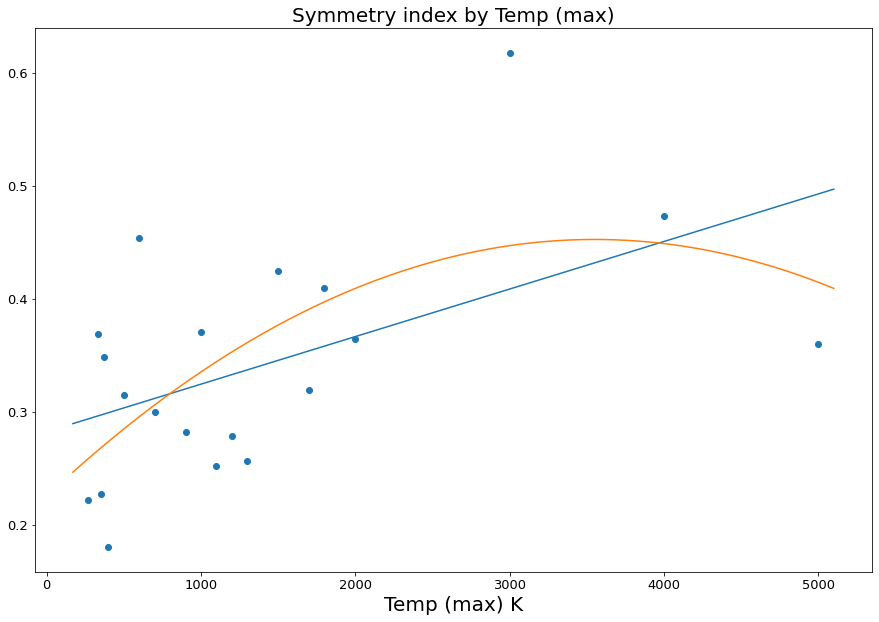

In [98]:
scatter_crit(T_MAX, 'graph_scatter_tmax', nums=True)

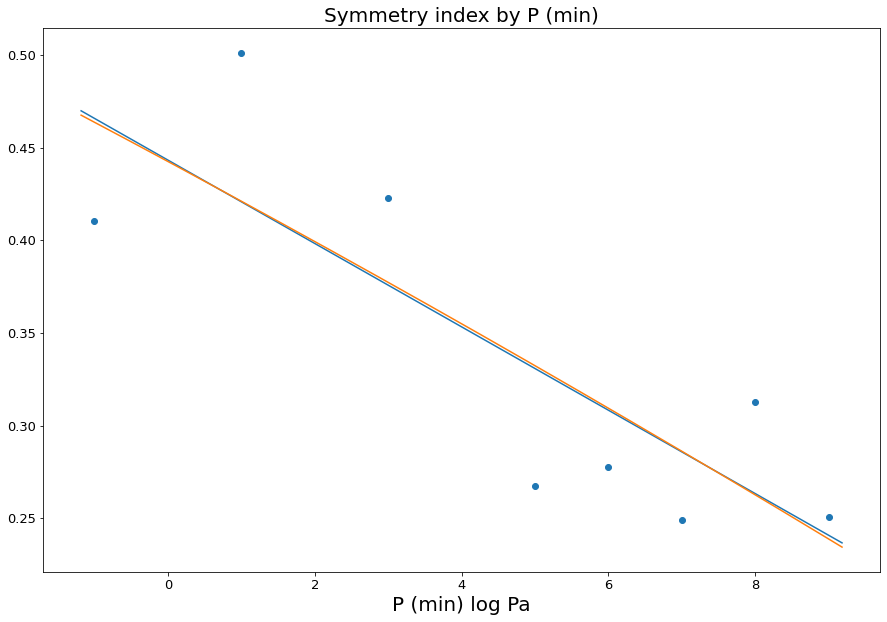

In [99]:
scatter_crit(P_MIN, 'graph_scatter_pmin', nums=True)

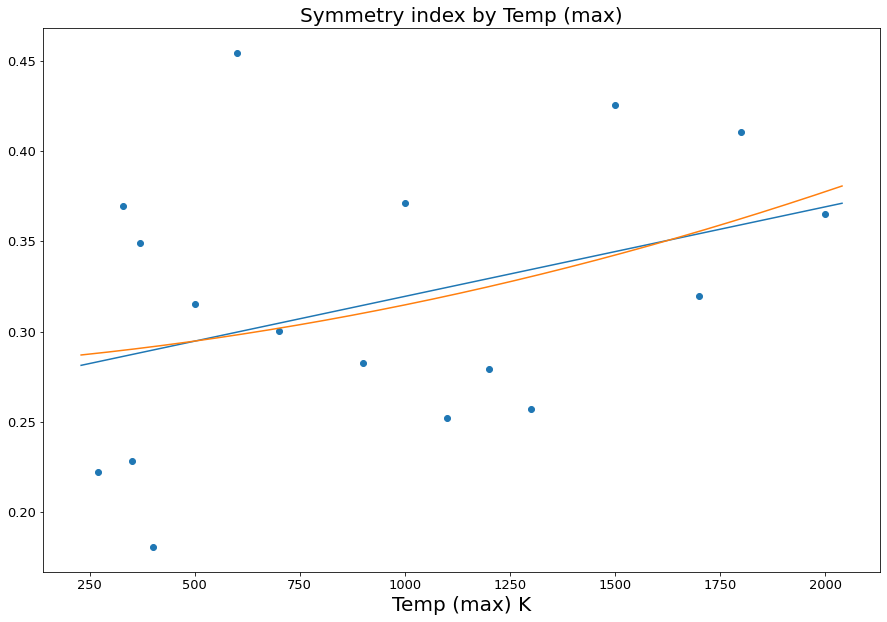

In [101]:
scatter_crit(T_MAX, 'graph_scatter_tmax', nums=True, end=-3)

In [47]:
polyfit(tmin_vals, tmin_syms, 1)

array([2.88609635e-01, 6.21521510e-05])